In [1]:
# PACKAGES
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import statistics as st
import pandas as pd
import os
import statsmodels.api as sm
import re
from stargazer.stargazer import Stargazer
from linearmodels.panel import PanelOLS # conda install -c conda-forge linearmodels

# FUNCTIONS FROM PACKAGES
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression

# SEABORN THEME
scale = 0.4
W = 16*scale
H = 9*scale
sns.set(rc = {'figure.figsize':(W,H)})
sns.set_style("white")

# WORKING DIRECTORY
mywd = "/Users/echiarot/Documents/GitHub/python_learn/Class Data Science"
os.chdir(mywd)

ModuleNotFoundError: No module named 'linearmodels'

- A large strand of applied econometrics deal with cross-sections of countries, households, or firms, which are followed over time. This type of data is called panel (or longitudinal) data.
- Definition (panel data). A longitudinal, or panel, dataset is one that follows a given sample of individuals over time, and thus provides multiple observations on each individuals of the sample. (Hsiao (2003), "Analysis of Panel data", second edition, p.2).
- Note: The second dimension of panel data is typically time, and we call it "time" here, but it needs not to be time.
- We call a balanced panel a dataset for which the number of time observations is the same for all countries. We will assume in this lecture that we have a balanced panel. However, in real life in most cases we will have access to unbalanced panels. This will be due to missing observations. This is usually not a problem; the theory discussed here applies to unbalanced panels as well, as long as missing observations are not missing in an "endogenous" way, in the sense that the fact that they are missing does not depend on the dependent variable. We will not discuss sample selection. So let's assume that the sample is balanced or that selection is "exogenous".
- Note that panel data is is different from repeated (also called "pooled") cross-sectional data, in which we observe different countries at several points of time. Pooled cross-sections can be useful to get a larger sample and therefore more precise estimates (remember that the standard errors of OLS estimates decrease with the total sample variation of the variable).
- Let's get some balanced data:

In [2]:
# get data
link = "https://www.qogdata.pol.gu.se/data/qog_ei_sept21.xlsx"
df_qog = pd.read_excel(link)

In [3]:
# get variables
indexes = ["ccodealp","year"]
variabs_co2 = ["edgar_co2gdp","edgar_co2t","edgar_co2pc"]
variabs_control = ["oecd_cctr_gdp"]
variabs = variabs_co2 + variabs_control
df = df_qog.loc[:,np.append(indexes,variabs)]

# make gdp per capita
df["gdp"] = (df["edgar_co2gdp"]/df["edgar_co2t"])**(-1) # billions US dollars
df["pop"] = (df["edgar_co2pc"]/df["edgar_co2t"])**(-1) # millions
df["gdp_pc"] = df["gdp"]/df["pop"] # thousands of US dollars
variabs = np.append(variabs, ["gdp","pop","gdp_pc"])

# put ones into data
df["ones"] = 1

# drop nas
df = df.dropna()

In [4]:
# describe
df.describe()

,year,edgar_co2gdp,edgar_co2t,edgar_co2pc,oecd_cctr_gdp,gdp,pop,gdp_pc,ones
count,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.000000,1968.0
mean,2006.558943,0.243792,244.822353,5.525416,76.901269,696.540916,44.117529,21.766931,1.0
std,6.878167,0.172754,953.697678,5.314153,31.627199,2085.847978,166.648815,19.054821,0.0
min,1994.000000,0.017499,0.103620,0.035062,0.000000,0.997115,0.090686,0.715969,1.0
25%,2001.000000,0.139422,4.879796,1.103488,72.921500,32.436325,3.451545,6.670379,1.0
50%,2007.000000,0.204393,24.277523,4.147764,90.376500,109.278612,9.883835,16.290105,1.0
75%,2012.000000,0.278301,103.328379,8.730894,99.383250,417.710330,24.991825,32.941329,1.0
max,2018.000000,1.154208,10671.339219,29.154586,108.098000,19062.770270,1397.030000,117.517686,1.0


In [5]:
# n of countries by year
df.groupby(['year']).size().reset_index(name='counts')

,year,counts
0,1994,57
1,1995,64
2,1996,65
3,1997,65
4,1998,68
5,1999,68
6,2000,76
7,2001,78
8,2002,78
9,2003,78


In [6]:
# from 2010 to 2016
df = df.loc[(df["year"] >= 2010) & (df["year"] <= 2017),:]
df.groupby(['year']).size().reset_index(name='counts')

,year,counts
0,2010,90
1,2011,89
2,2012,89
3,2013,90
4,2014,91
5,2015,86
6,2016,85
7,2017,82


<AxesSubplot:xlabel='gdp_pc', ylabel='edgar_co2pc'>

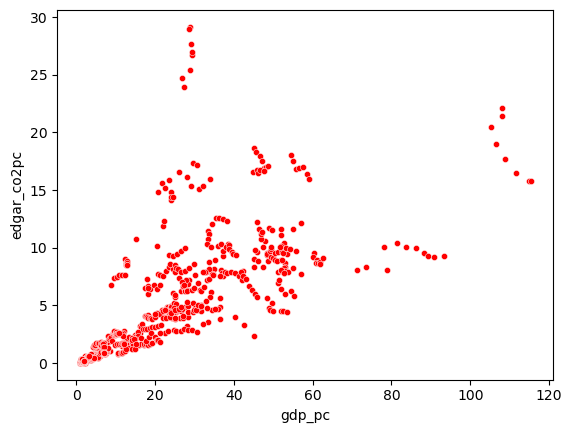

In [7]:
# plot
sns.scatterplot(x='gdp_pc', y='edgar_co2pc', data=df, color = "r", s = 20)

In [8]:
# drop outliers quick and dirty
df = df.loc[(df["gdp_pc"] < 65) & (df["edgar_co2pc"] < 20),:]
df.groupby(['year']).size().reset_index(name='counts')

,year,counts
0,2010,87
1,2011,86
2,2012,86
3,2013,87
4,2014,88
5,2015,82
6,2016,81
7,2017,78


In [9]:
# lets make it balanced for simplicity
df_agg = df.groupby(['year']).size().reset_index(name='counts')
year_min = df_agg.loc[df_agg.counts == min(df_agg.counts),"year"].values
ccodealp_sub = np.unique(df.loc[df.year == int(year_min),"ccodealp"].values)
df = df.loc[np.isin(df.ccodealp, ccodealp_sub),:]

df_agg = df.groupby(['ccodealp']).size().reset_index(name='counts')
cou_drop = df_agg.loc[df_agg.counts == min(np.unique(df_agg["counts"])),"ccodealp"].values
df = df.loc[~np.isin(df.ccodealp, cou_drop),:]

df.groupby(['year']).size().reset_index(name='counts')

,year,counts
0,2010,77
1,2011,77
2,2012,77
3,2013,77
4,2014,77
5,2015,77
6,2016,77
7,2017,77


<AxesSubplot:xlabel='gdp_pc', ylabel='edgar_co2pc'>

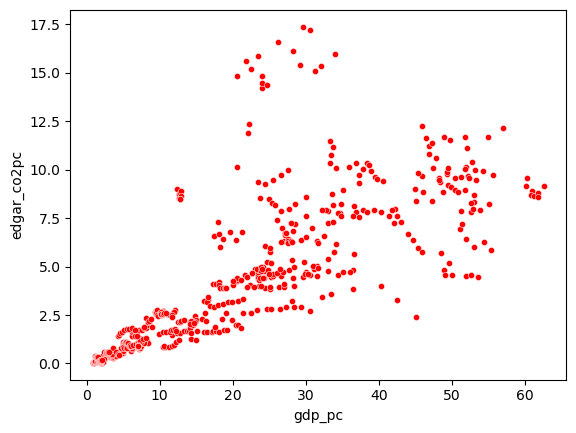

In [10]:
# plot
sns.scatterplot(x='gdp_pc', y='edgar_co2pc', data=df, color = "r", s = 20)

<AxesSubplot:xlabel='ln_gdp_pc', ylabel='ln_edgar_co2pc'>

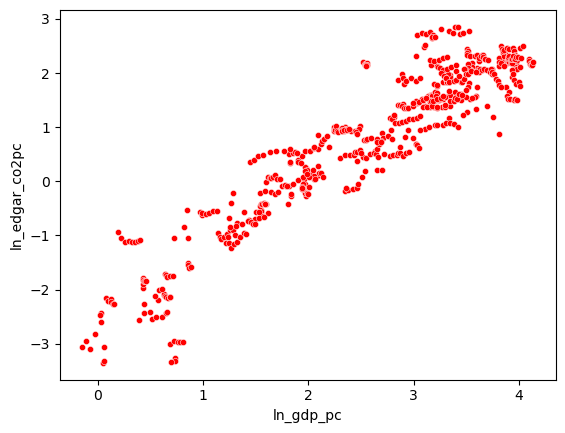

In [11]:
# maybe logs?
df["ln_gdp_pc"] = np.log(df["gdp_pc"])
df["ln_edgar_co2pc"] = np.log(df["edgar_co2pc"])

# plot
sns.scatterplot(x='ln_gdp_pc', y='ln_edgar_co2pc', data=df, color = "r", s = 20)

- During last class, we have explored whether higher income leads to higher emissions, possibly through higher consumption. We have used a cross-sectional sample of 94 countries to estimate that, on average, if GDP per capita increases by 1%, we'd expect CO2 emissions per capita to increase by around 1.3245 %. This estimate comes from a specification that includes also a measure for carbon-tax revenues, as we believe that this variable can be a source of omitted-variable bias.
- Now can our estimate still be biased? Maybe. For example, let's think about how cultural traits can lead people to generally pollute less. We could make the case that some countries have a culture of extending the life of products and re-use, at least more than other countries. This aspect may come from the way people in these countries prepare food, their religious beliefs, etc. As a result, people in these countries consume less in general, and therefore they may consume also less carbon-intensive goods and services. If these countries with such a cultural trait are also generally poorer (plausible), then we might be overestimating the impact of income on emissions. Indeed, we might be seeing a huge difference in CO2 emissions between poor and rich countries mainly because rich countries have no culture for recycling and re-using. So it is not because I am rich that I pollute more, but it is because of my culture. If I were poor, I'd still pollute a lot.
- So how can we disentangle the impact of income per se and culture on emissions? Cultural aspects are generally unobservable, so we can't simply find a variable (observable) that controls for them. What we can do is using panel data and include countries' fixed effects.
- Let us re-write the model for the data generating process with 2 regressors in a panel-data setup, for $i=1,...,N$ and $t=1,...,T$:
<br><br>
$$
y_{it} = \beta_0 + \beta_1 x_{1,it} + \beta_2 x_{2,it} + \delta u_i + \epsilon_{it}
$$
<br>
- The new term $u_i$ refers to country-specific unobservable characteristics that might be related with $x_{2,it}$ and also affect $y_{it}$, such as the cultural aspects mentioned above. The important point is that we cannot observe them, so we can't just control for them by including them in our regression, as we did for $x_{2,it}$. So how do we do?
- The trick is that, rather than having 1 variable for $u_i$ with data on a specific (unobservable) aspect, we can include N country dummies which equal 1 for a given country and zero otherwise, and which capture any specific characteristic of a specific country.

Conceptually, for $i=1,...,N$ and $t=1,...,T$:
<br><br>
$$
y_{it} = \beta_0 + \beta_1 x_{1,it} + \beta_2 x_{2,it} + \delta_1 u_{1,i} + ... + \delta_N u_{N,i} + \epsilon_{it}
$$
<br>
- Let's write this model in expanded data-matrix notation, so we get a sense of what these dummies look like:
<br><br>
$$
\begin{bmatrix}
y_{11} \\
\vdots \\
y_{1T} \\
- \\
\vdots \\
- \\
y_{N1} \\
\vdots \\
y_{NT}
\end{bmatrix} = 
\beta_0
\begin{bmatrix}
1 \\
\vdots \\
1 \\
- \\
\vdots \\
- \\
1 \\
\vdots \\
1
\end{bmatrix} +
\beta_1
\begin{bmatrix}
x_{1,11} \\
\vdots \\
x_{1,1T} \\
- \\
\vdots \\
- \\
x_{1,N1} \\
\vdots \\
x_{1,NT}
\end{bmatrix} +
\beta_2
\begin{bmatrix}
x_{2,11} \\
\vdots \\
x_{2,1T} \\
- \\
\vdots \\
- \\
x_{2,N1} \\
\vdots \\
x_{2,NT}
\end{bmatrix} +
\delta_1
\begin{bmatrix}
1 \\
\vdots \\
1 \\
- \\
\vdots \\
- \\
0 \\
\vdots \\
0
\end{bmatrix} + ... +
\delta_N
\begin{bmatrix}
0 \\
\vdots \\
0 \\
- \\
\vdots \\
- \\
1 \\
\vdots \\
1
\end{bmatrix} + 
\begin{bmatrix}
\epsilon_{11} \\
\vdots \\
\epsilon_{1T} \\
- \\
\vdots \\
- \\
\epsilon_{N1} \\
\vdots \\
\epsilon_{NT}
\end{bmatrix}
$$
<br>

- Or in a more compact way:
<br><br>
$$
\begin{bmatrix}
y_{11} \\
\vdots \\
y_{1T} \\
- \\
\vdots \\
- \\
y_{N1} \\
\vdots \\
y_{NT}
\end{bmatrix} = 
\begin{bmatrix}
1 & x_{1,11} & x_{1,11} \\
\vdots & \vdots & \vdots \\
1 & x_{1,1T} & x_{1,1T} \\
- & - & - \\
\vdots & \vdots & \vdots \\
- & - & - \\
1 & x_{1,N1} & x_{1,N1} \\
\vdots \\
1 & x_{1,NT} & x_{1,NT}
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2
\end{bmatrix}
+
\begin{bmatrix}
1 & \dots & 0 \\
\vdots & \vdots & \vdots \\
1 & \dots & 0 \\
- & & - \\
\vdots & \vdots & \vdots \\
- & & - \\
0 & \dots & 1 \\
\vdots \\
0 & \dots & 1 \\
\end{bmatrix}
\begin{bmatrix}
\delta_1 \\
\vdots \\
\delta_N
\end{bmatrix} + 
\begin{bmatrix}
\epsilon_{11} \\
\vdots \\
\epsilon_{1T} \\
- \\
\vdots \\
- \\
\epsilon_{N1} \\
\vdots \\
\epsilon_{NT}
\end{bmatrix}
$$
<br>

- Or in standard matrix notation:
$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{U}\boldsymbol{\delta} + \boldsymbol{\epsilon}  \qquad \text{with } \boldsymbol{\epsilon} | \boldsymbol{X} \sim \mathcal{N}(\boldsymbol{0}_{NT},\,\sigma^2\boldsymbol{I}_{NT})
$$
- Aright. So the dummies capture any country specific characteristic. If we looks at the expanded matrixes, it becomes clear what the $\delta$ coefficients are. As you remember well, we saw that the coefficient related to a vector of ones, i.e. $\beta_0$, is the mean of $y$ when the other covariates equal zero (intercept). In a similar way, $\delta_1$ is the mean of $y$ for country 1 when the other covariates equal zero. Hold this thought, we'll use it in a second.
- So cool, if we want to estimate this panel-data model, we can simply add these dummies, estimate the $\delta$ coefficients, and we'd have controlled for any unobserved country-specific source of endogeneity. Right? Yes and no. We can definitely do it, and we will, just if we do it we might have a computational issue. Think if we have to do this for like 250 countries, or 1 million individuals. We'd need to include 250 country dummies, so our data matrixes would be huge, and inverting huge matrixes is very expensive in computation terms. Is there another way of doing an OLS estimation, in which we avoid inverting huge matrixes? It turns out that there is, and the first step to understand this methodology is starting from the Frisch-Waugh-Lovell partitioned regression theorem. In a nutshell, this theorem says that if we split our regressors in 2 matrixes, we can obtain the OLS coefficients related to the first matrix with the following steps: (i) regress $y$ on the second matrix, (ii) regress the first  matrix on the second matrix, (iii) compute the residuals of (i) and the residuals of (ii), (vi) regress the residuals obtained in (i) on the residuals obtained in (ii), and the coefficient estimates of this last step will be the coefficient estimates related to the first matrix. If we apply this to our panel-data model, we can think of $X$ as the first matrix and $U$ as the second matrix. So in our case these steps would be:
    - Estimate $\hat{\boldsymbol{y}}=\boldsymbol{U}\hat{\boldsymbol{\delta}}_{1,OLS}^*$
    - Estimate $\hat{\boldsymbol{X}}=\boldsymbol{U}\hat{\boldsymbol{\delta}}_{2,OLS}^*$
    - Get residuals of first regression $\tilde{\boldsymbol{y}}$ and of second regression $\tilde{\boldsymbol{X}}$
    - Estimate $\tilde{\boldsymbol{y}} = \tilde{\boldsymbol{X}}\hat{\boldsymbol{\beta}}_{OLS}$
- OK so that's the principle. Now it comes the trick. In the first step what we are doing is regressing $\hat{\boldsymbol{y}}$ only on country dummies. The coefficient estimates of these country dummies in this regression represent the country-level sample means of $\hat{\boldsymbol{y}}$. Remember that the mean of $\hat{\boldsymbol{y}}$ is the coefficient estimate related a vector of ones (mean model). So the mean of $\hat{\boldsymbol{y}}$ in country 1 will be the coefficient estimate related to a vector that equals 1 for country 1 and 0 otherwise. The mean of $\hat{\boldsymbol{y}}$ in country 2 will be the sum of the coefficient estimate for the first country and the coefficient estimate related to a vector that equals 1 for country 2 and 0 otherwise.
- Let's do an example in which we run a regression with only year dummies as regressors (instead of country dummies, but it's the same principle). In Python, it can be done in the following way:

In [ ]:
# dummy reg on years
est_ols = sm.OLS.from_formula("ln_edgar_co2pc ~ C(year)", data=df).fit()
est_ols.summary().tables[1]

- So the mean of `ln_edgar_co2pc` for year 2010 (automatically assigned as the first year) is 0.7153. Then, the mean of `ln_edgar_co2pc` for year 2011 is 0.7153 + 0.0138 = 0.7291. Then, the mean of `ln_edgar_co2pc` for year 2011 is 0.7153 + 0.0522 = 0.7675. Etc.
- Let's now compute the mean by year in the standard way:

In [ ]:
# compute mean by year
df.groupby("year")["ln_edgar_co2pc"].mean()

- Yes the mean of `ln_edgar_co2pc` for 2010 is 0.7153, for 2011 is 0.7291, for 2012 is 0.7675, etc.
- OK so goign back to our steps and our country dummies. So to estimate the coefficients in our step (i), we do not have to do it through the usual OLS regression approach - which would imply inverting the dummy matrix (computationally expensive) - but we can simply obtain these estimates by computing the country-specific means for `ln_edgar_co2pc`. The same holds for step (ii), so we just need to compute the country-specific means for `ln_gdp_pc` and `oecd_cctr_gdp`. Let's do it:

In [ ]:
# compute means by country
y = "ln_edgar_co2pc"
X = ["ln_gdp_pc","oecd_cctr_gdp"]
mean_df = df.groupby("ccodealp")[[y] + X].mean()
mean_df.head()

- OK so now we have to compute the residuals. Let's store our means in vectors $\overline{\boldsymbol{y}}$ and  $\overline{\boldsymbol{X}}$ that look like this:
<br><br>
$$
\overline{\boldsymbol{y}} = 
\begin{bmatrix}
\overline{y}_{1} \\
\vdots \\
\overline{y}_{1} \\
- \\
\vdots \\
- \\
\overline{y}_{N} \\
\vdots \\
\overline{y}_{N} \\
\end{bmatrix}
\qquad
\qquad
\overline{\boldsymbol{X}} = 
\begin{bmatrix}
\overline{x}_{1,1} & \overline{x}_{2,1} \\
\vdots \\
\overline{x}_{1,1} & \overline{x}_{2,1} \\
- \\
\vdots \\
- \\
\overline{x}_{1,N} & \overline{x}_{2,N} \\
\vdots \\
\overline{x}_{1,N} & \overline{x}_{2,N} \\
\end{bmatrix}
$$
<br>
- So we can obtain our residuals for steps (i) and (ii) in the following way:
    - $\tilde{\boldsymbol{y}} = \boldsymbol{y} - \overline{\boldsymbol{y}}$
    - $\tilde{\boldsymbol{X}} = \boldsymbol{X} - \overline{\boldsymbol{X}}$
- Note that for this to hold, our $\boldsymbol{U}$ and \boldsymbol{X} matrixes are not exactly as the ones we have said above, as the vector of ones for the intercept is not contained in $\boldsymbol{X}$ but is contained in $\boldsymbol{U}$ and substitutes the first country. Pas grave (no big deal).
- So let's do step (iii) compute the residuals for step (i) and (ii) in this clever way in Python. To do that, we need to set the indexes of our data as the country iso codes:

In [ ]:
# compute demeaned df
demeaned_df = (df
               .set_index("ccodealp") # set the index as the person indicator
               [[y] + X]
               - mean_df) # subtract the mean data

demeaned_df.head()

- Finally, step (iv), let's regress the residuals from step (i) on the residuals of step (ii). Formally we estimate:
<br><br>
$$
\tilde{\boldsymbol{y}} = \tilde{\boldsymbol{X}}\boldsymbol{\beta} + \tilde{\boldsymbol{\epsilon}}
$$
<br>
- Another way of saying that we have controlled for country dummies without actually running the regressions, is saying that we have "wiped out" the all unobserved (and observed) variables that are constant across time. To see that, just re-write the model in demeaned terms (we do this without the matrix notation for simplicity). For $i=1,...,N$ and $t=1,...,T$:
<br><br>
$$
(y_{it} - \overline{y}_{it}) = (\beta_0 - \beta_0) + \beta_1 (x_{1,it} -  \overline{x}_{1,it}) + \beta_2 (x_{2,it} -  \overline{x}_{2,it}) + \delta (u_i - u_i) + (\epsilon_{it} - \overline{\epsilon}_{it})
$$
<br>
- So let's do the regression of the residuals from step (i) on the residuals from step (ii) to obtain our  estimates for $\beta$, which we'll call fixed effect estimates obtained with the FE estimator $\hat{\boldsymbol{\beta}}_{FE}$ (as they are as if we were controlling for all these country dummies):

In [ ]:
# compute with ols fe estimator
est_fe = sm.OLS.from_formula(f"{y} ~ {'+'.join(X)}", data=demeaned_df).fit()
est_fe.summary().tables[1]

- The estimate for `ln_gdp_pc` is much lower than before! This means that, indeed, it is possible that much of the effect that we were measuring before was driven by country-specific characteristics, and not by the average effect of income on emissions. Note that the result is still statistically significant. Cool.
- VERY IMPORTANT POINT: the interpretation of the coefficient does not change and it remains the usual one.
- As we love matrix notation and our own functions so much, let's do the same by hand. If we want to keep using the matrix notation we used for the OLS, we need to come up with a matrix that demeans the data. Let's define $\boldsymbol{\iota}_T$ as a T-dimensional column vector of ones. Let us then define the following $(NT\times NT)$ matrix $\boldsymbol{P}$ that computes the means of data matrixes and stores them in the stacked way we saw above:
<br><br>
$$
\boldsymbol{P}=\boldsymbol{I}_N \otimes \frac{1}{T}\boldsymbol{\iota}_T\boldsymbol{\iota}_T'
$$
<br>
- Let's then use this matrix to compute a $(NT\times NT)$ matrix $\boldsymbol{Q}$ that de-means the data:
<br><br>
$$
\boldsymbol{Q}=\boldsymbol{I}_{NT} - \boldsymbol{P}
$$
<br>
- OK so our demeaned model can be written as:
<br><br>
$$
\boldsymbol{Q}\boldsymbol{y} = \boldsymbol{Q}\boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{Q}\boldsymbol{\epsilon}
$$
<br>
- Which, as by construction $\tilde{\boldsymbol{y}}=\boldsymbol{Q}\boldsymbol{y}$, $\tilde{\boldsymbol{X}}=\boldsymbol{Q}\boldsymbol{X}$, and $\tilde{\boldsymbol{\epsilon}} = \boldsymbol{Q}\boldsymbol{\epsilon}$, is the model we wrote before:
<br><br>
$$
\tilde{\boldsymbol{y}} = \tilde{\boldsymbol{X}}\boldsymbol{\beta} + \tilde{\boldsymbol{\epsilon}}
$$
<br>
- OK let's create a FE function along the lines of our OLS function:

In [ ]:
# function to transform panda series into vectors / matrices
def data_to_matrix(data, variab_name):
    
    """ My Data to Matrix Function """
    
    # store in matrixes
    matrix = data.loc[:,variab_name].to_numpy()
    
    # make column vectors for arrays with less than 2 dimensions
    if len(matrix.shape) == 1:
        matrix = np.atleast_2d(matrix).T
        
    # return result
    return matrix

# FE function
def FE_estimator(data, y, X, indexes):
    
    """ My Sample Mean Function """
    
    # store in matrixes
    ydata = data_to_matrix(data, variab_name = y)
    xdata = data_to_matrix(data, variab_name = X)
    
    # get params
    N = len(data[indexes[0]].unique())
    T = len(data[indexes[1]].unique())
    K = xdata.shape[1]
    DF = N*T-K-N
    
    # demean
    iota = np.atleast_2d(np.ones(T)).T
    P = np.kron(np.identity(N), 1/T * iota @ iota.T)
    Q = np.identity(N*T) - P
    ydata_dem = Q @ ydata
    xdata_dem = Q @ xdata

    # get OLS estimate
    betahat_FE = (inv(xdata_dem.T @ xdata_dem)) @ (xdata_dem.T @ ydata_dem)
    
    # get standard errors
    resid_FE = (ydata_dem - xdata_dem @ betahat_FE)
    sigma2hat_FE = (resid_FE.T @ resid_FE) / DF
    betahat_FE_vcov = sigma2hat_FE * inv(xdata_dem.T @ xdata_dem)
    sehat_FE = np.atleast_2d(np.sqrt(betahat_FE_vcov.diagonal())).T
    
    # get t stat
    t_stat_FE = betahat_FE / sehat_FE
    
    # get p values and confidence intervals
    
    # create objects to store results
    p_values_FE = np.empty((K,1,))
    ci_low_FE = np.empty((K,1,))
    ci_high_FE = np.empty((K,1,))
    
    # run loop
    for i in range(K):
        
        # get p value
        lower_area = stats.t.cdf(-abs(float(t_stat_FE[i])), df = DF)
        upper_area = lower_area
        p_value = lower_area + upper_area
        p_values_FE[i] = p_value

        # get confidence interval
        alpha_inv = (1.0-0.05)
        q1 = (1+alpha_inv)/2
        ci_critical = stats.t.ppf(q1, DF)
        ci_low_FE[i] = betahat_FE[i]-(ci_critical*sehat_FE[i])
        ci_high_FE[i] = betahat_FE[i]+(ci_critical*sehat_FE[i])

    # get table
    df_res = pd.DataFrame(index=np.arange(K), columns=np.arange(7))
    df_res.columns = ["variable","coef","std err","t","P>|t|","[0.025","0.975]"]
    df_res["variable"] = X
    df_res["coef"] = np.around(betahat_FE, 4)
    df_res["std err"] = np.around(sehat_FE, 3)
    df_res["t"] = np.around(t_stat_FE, 3)
    df_res["P>|t|"] = np.around(p_values_FE, 3)
    df_res["[0.025"] = np.around(ci_low_FE, 3)
    df_res["0.975]"] = np.around(ci_high_FE, 3)

    # return
    return df_res

- Note that we have added an extra $N$ in the degrees of freedom correction, because all of this is as if we were estimating also $N$ country dummies (even if we don't effectively do it, we can't cheat statistics).
- Let's try it:

In [ ]:
# our function
FE_estimator(data = df, y = ["ln_edgar_co2pc"], X = ["ln_gdp_pc","oecd_cctr_gdp"], 
             indexes = ["ccodealp","year"])

- Let's compare it with the canned method used above:

In [ ]:
# canned method
est_fe = sm.OLS.from_formula("ln_edgar_co2pc ~ ln_gdp_pc + oecd_cctr_gdp - 1", data=demeaned_df).fit()
est_fe.summary().tables[1]

- Mhm same coefficient estimates but different test statistics!!
- Let's try with another canned method for panel OLS to see if it's us the problem:

In [ ]:
# another canned method
est_fe_canned = PanelOLS.from_formula("ln_edgar_co2pc ~ ln_gdp_pc + oecd_cctr_gdp + EntityEffects",
                            data=df.set_index(["ccodealp", "year"]))
result = est_fe_canned.fit()
result.summary.tables[1]

- This one gives the same of ours!! OK so there must be something in the standard canned method that is not appropriate for panel-data test statistics, maybe the degrees of freedom with demeaned data are wrong. We'll discuss this another time.
- One thing we never covered in class is heteroscedasticity. This is a huge topic. For now let's just say that you always need to use robust standard errors, both in cross-sectional and panel-data analysis. In panel data, the most common way to have robust standard errors is clustering them, usually at the country level (or individual level). Let's do it with the canned method:

In [ ]:
# canned method with SE clustered at the country level
est_fe_canned = PanelOLS.from_formula("ln_edgar_co2pc ~ ln_gdp_pc + oecd_cctr_gdp + EntityEffects",
                            data=df.set_index(["ccodealp", "year"]))

result = est_fe_canned.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

- WOAH! When we use robust standard error (clustered at the country level) the coefficient estimate for `ln_gdp_pc` is no longer statistically significant at the 10% level!! This is huge. So basically we are saying that, after we control for country-specific unobservables, GDP per capita is no longer useful to predict CO2 emissions per capita. So it's all about country-specific unonservables, that can be culture and other stuff!! That's mind blowing.
- To see the size of the bias, you can estimate the panel-data model without taking into account for the fixed effects. Let's do it with the canned function:

In [ ]:
# compute with ols pooled
est_pool_canned = PanelOLS.from_formula("ln_edgar_co2pc ~ ln_gdp_pc + oecd_cctr_gdp",
                            data=df.set_index(["ccodealp", "year"]))

result = est_pool_canned.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

- Finally, to understand better FE, let's try to visualize them.
- Let's subset our data:

In [ ]:
# subset
df_plot = df[(df["ln_gdp_pc"] > 2) & (df["ln_gdp_pc"] < 3)].copy()

# estimate ols and store fitted values
est_ols = sm.OLS.from_formula("ln_edgar_co2pc ~ ln_gdp_pc", data=df_plot).fit()
df_plot["fitted_values"] = est_ols.fittedvalues

# plot observations
sns.scatterplot(x='ln_gdp_pc', y='ln_edgar_co2pc', data=df_plot, color = "r", s = 20)

# plot ols fit line (crossing fitted values)
sns.lineplot(x='ln_gdp_pc', y='fitted_values', data=df_plot)

In [ ]:
# subset
df_plot = df[(df["ln_gdp_pc"] > 2) & (df["ln_gdp_pc"] < 3)].copy()

# estimate ols and store fitted values
est_ols = sm.OLS.from_formula("ln_edgar_co2pc ~ ln_gdp_pc", data=df_plot).fit()
df_plot["fitted_values"] = est_ols.fittedvalues

# estimate fe with dummies and store fitted values
est_fe = sm.OLS.from_formula("ln_edgar_co2pc ~ ln_gdp_pc + C(ccodealp)", data=df).fit()
df_plot["fitted_values_fe"] = est_fe.fittedvalues

# plot observations
sns.scatterplot(x='ln_gdp_pc', y='ln_edgar_co2pc', data=df_plot, hue="ccodealp", legend = False)

# plot fe fit lines (crossing fitted values)
for ccodealp in df_plot["ccodealp"].unique():
    df_temp = df_plot.query(f"ccodealp=='{ccodealp}'")
    sns.lineplot(x='ln_gdp_pc', y='fitted_values_fe', data=df_temp)

- Take a minute to appreciate what the image above is telling you about what fixed effect is doing. Notice that fixed effect is fitting one regression line per country. Also notice that the lines are parallel. The slope of the line is the effect of GDP per capita on CO2 emissions per capita. So the fixed effect is assuming that the causal effect is constant across all countries.
- Something that we did not cover is time fixed effects, and two-way fixed effects, which can be estimated with the canned function.